In [1]:
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import numpy as np
import io
import re
import string
import tqdm
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
import contractions

import matplotlib.pyplot as plt

import nlpaug.augmenter.word as naw
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0],True)

2022-11-10 14:35:50.037642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 14:35:50.037667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-10 14:35:55.119334: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-10 14:35:55.119769: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 14:35:55.119874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.s

In [2]:
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

### We are using dataset from https://data.world/crowdflower/sentiment-analysis-in-text

In [3]:
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("./data/text_emotion.csv")

In [4]:
cleaned_df = df.copy()
# lowercasing 'content' column
cleaned_df['content'] = cleaned_df['content'].str.lower()

# expanding contractions
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: contractions.fix(sentence))

# remove anything http
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('.*http.*','',word) for word in sentence.split()]))

# removing all words with #hastag and @name and urls
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('@.*','',word) for word in sentence.split()]))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('#.*','',word) for word in sentence.split()]))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([re.sub('.*www\..*','',word) for word in sentence.split()]))

# removing words with digits like game57
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: re.sub('\w*\d+\w*','',sentence))

# removing all punctuation marks
exclude = set(string.punctuation)
regex = re.compile('[%s]' % re.escape(string.punctuation))
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: regex.sub("",sentence))

# removing unicode characters
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: sentence.encode("ascii","ignore").decode())

# removing stopwords
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([word for word in sentence.split() if word not in stop_words]))

# lemmatization
lemmatizer = WordNetLemmatizer()
cleaned_df['content'] = cleaned_df['content'].apply(lambda sentence: " ".join([lemmatizer.lemmatize(word) for word in sentence.split()]))

# remove empty sentences
cleaned_df= cleaned_df[cleaned_df['content'] != '']

# dropping unecessary columns
cleaned_df = cleaned_df.drop(columns=['tweet_id','author']).sample(frac=1).reset_index(drop=True)

# Using word2vec skip-gram algorithm to get non-contextual word vectors

### Finding the length of the maximum sentence, and vocab size in the dataset

In [5]:
max_length = cleaned_df['content'].apply(lambda s: len(s.split())).max()
no_of_words = cleaned_df['content'].apply(lambda content: len(content.split())).sum()


# count vocab size
cache=set()

#counting padding and [unkownd] token
vocab_size= 1
for key,sentence in cleaned_df['content'].items():
    words = sentence.split()
    for word in words:
        if(word not in cache):
            vocab_size+=1
            cache.add(word)
            
print("max sentence length of 'content' is {}".format(max_length))
print("total number of words of content is {}".format(no_of_words))
print("total number of unique words/vocab_size of content is {}".format(vocab_size))

max sentence length of 'content' is 25
total number of words of content is 269556
total number of unique words/vocab_size of content is 31045


### function to generate training data

In [6]:
def generate_training_data(sequences, window_size,num_ns,vocab_size,seed):
    
    # each training sentence is appended to these list
    targets,contexts,labels = [],[],[]
    
    # sampling table for vocab_size tokens
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # iterate over all sentences in dataset
    for sequence in tqdm.tqdm(sequences):
       

        # generating positive skip-gram pairs for a sequence
        positive_skip_grams,_ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size = vocab_size,
            sampling_table=sampling_table,
            window_size=window_size, # TODO: change window size
            negative_samples=0
        )
        
        # produce negative samples and create training samples (x_train,labels)
        for target_word, context_word in positive_skip_grams:
    
    
            # expand context word to frmo dim shape (1,0) to (1,1)
            context_class = tf.expand_dims(
                tf.constant([context_word],dtype='int64'),1)
            negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
                true_classes=context_class, # to tell the which sample is positive
                num_true=1,
                num_sampled=num_ns,
                unique=True,
                range_max=vocab_size, #TODO: may need to change to just the negative samples of the sentence itself instead of the entire vocab
                seed=seed,
                name='negative_sampling')
    
    
            # building the context and label vectors for a target word
            context = tf.concat([tf.squeeze(context_class,1),negative_sampling_candidates],0)
            label = tf.constant([1] + [0]*num_ns, dtype="int64")
    
    
            # append each element from the training ex to global lists
            targets.append(target_word)
            contexts.append(context)
            labels.append(label)
    
    
    return targets, contexts, labels 
            
            

### Vectorizing all vocab found in cleaned_df

In [7]:
vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=int(max_length))

2022-11-10 14:36:22.076378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### replace vocab with their respective tokens:

In [8]:
BATCH_SIZE = 64

In [9]:
# creating a dataset of all sentences
text_ds = tf.data.Dataset.from_tensor_slices(cleaned_df['content'])
vectorize_layer.adapt(text_ds.batch(BATCH_SIZE))

### build a inverse vocab which maps indexes -> words which can be handy

In [10]:
inverse_vocab = vectorize_layer.get_vocabulary()

In [11]:
# Vectorize the data in text_ds.
# prefetch does fetching of data and training at the same time using multiple thread
# improving performance
text_vector_ds = text_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()

### As you can see we have successfully vectorised our sentences/sequences

In [12]:
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

39746


## Using unsupervised learning (word2Vec skip_gram) to predict context from targets. 
>While doing so, we are also training the weights on the embeddings. We can increase window size so that the embeddings learn more contextutal knowledge with respect to the words around them

In [13]:
# to determine window size, we see the median length of a sentence

print(cleaned_df['content'].apply(lambda s: len(s.split())).median())
print(cleaned_df['content'].apply(lambda s: len(s.split())).mean())

6.0
6.7819654808031


### We go with window size of 2 since that the median length of a sentence is 6. we want to offer 4 slots some space for negative sampling

In [17]:
# note higher window size is more computationally expensive
# from documentation, it is said that for small datasets, negative samples of range 5to 20 yields the best results

WINDOW_SIZE = 2
num_ns = 4

targets, contexts, labels = generate_training_data(
    sequences=sequences,
    window_size=WINDOW_SIZE,
    num_ns=num_ns,
    vocab_size=vocab_size,
    seed=SEED)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print('\n')
print(f"targets.shape: {targets.shape}")
print(f"contexts.shape: {contexts.shape}")
print(f"labels.shape: {labels.shape}")

100%|████████████████████████████████████| 39746/39746 [00:55<00:00, 720.32it/s]




targets.shape: (228172,)
contexts.shape: (228172, 5)
labels.shape: (228172, 5)


### Configuring training sets for Word2Vec model

In [18]:
# batching the dataset
BUFFER_SIZE = 10000
dataset = tf.data.Dataset.from_tensor_slices(((targets, contexts), labels))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset element_spec=((TensorSpec(shape=(64,), dtype=tf.int64, name=None), TensorSpec(shape=(64, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 5), dtype=tf.int64, name=None))>


In [19]:
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print(dataset)

<PrefetchDataset element_spec=((TensorSpec(shape=(64,), dtype=tf.int64, name=None), TensorSpec(shape=(64, 5), dtype=tf.int64, name=None)), TensorSpec(shape=(64, 5), dtype=tf.int64, name=None))>


In [20]:
class Word2Vec(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.target_embedding = layers.Embedding(vocab_size,
              embedding_dim,
              input_length=1,
              name="w2v_embedding")
        self.context_embedding = layers.Embedding(vocab_size,
               embedding_dim,
               input_length=num_ns+1)

    def call(self, pair):
        target, context = pair
        if len(target.shape) == 2:
            target = tf.squeeze(target, axis=1)
        word_emb = self.target_embedding(target)
        context_emb = self.context_embedding(context)
        dots = tf.einsum('be,bce->bc', word_emb, context_emb)
        return dots

In [21]:
# embedding size for a word is chosen to be 50

EMBEDDING_DIM = 50

word2vec = Word2Vec(vocab_size, EMBEDDING_DIM)
word2vec.compile(optimizer='adam',
                 loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
# call back to log training stats for TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [42]:
history = word2vec.fit(dataset, epochs=15, callbacks=[tensorboard_callback])

Epoch 1/15
3565/3565 [==============================] - 77s 21ms/step - loss: 1.5453 - accuracy: 0.2633
Epoch 2/15
3565/3565 [==============================] - 84s 24ms/step - loss: 1.3938 - accuracy: 0.4415
Epoch 3/15
3565/3565 [==============================] - 76s 21ms/step - loss: 1.1698 - accuracy: 0.6347
Epoch 4/15
3565/3565 [==============================] - 67s 19ms/step - loss: 0.8884 - accuracy: 0.7832
Epoch 5/15
3565/3565 [==============================] - 68s 19ms/step - loss: 0.6382 - accuracy: 0.8599
Epoch 6/15
3565/3565 [==============================] - 68s 19ms/step - loss: 0.4513 - accuracy: 0.9027
Epoch 7/15
3565/3565 [==============================] - 68s 19ms/step - loss: 0.3218 - accuracy: 0.9293
Epoch 8/15
3565/3565 [==============================] - 67s 19ms/step - loss: 0.2348 - accuracy: 0.9474
Epoch 9/15
3565/3565 [==============================] - 65s 18ms/step - loss: 0.1763 - accuracy: 0.9607
Epoch 10/15
3565/3565 [==============================] - 67s 19m

Text(0, 0.5, 'loss')

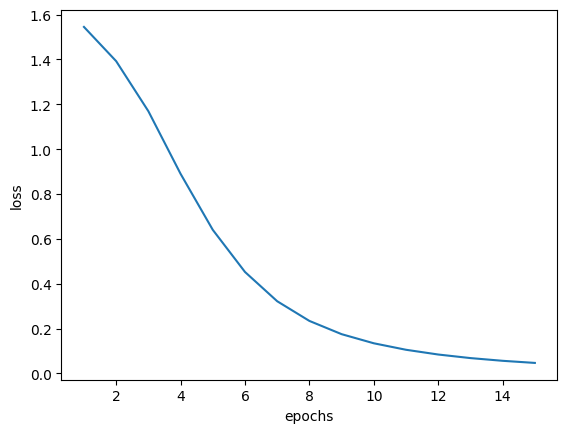

In [43]:
import matplotlib.pyplot as plt
y = history.history['loss']
x = [i+1 for i in range(0,len(y))]
plt.plot(x,y)
plt.xlabel('epochs')
plt.ylabel('loss')

### Writing vectors to file

In [44]:
weights = word2vec.get_layer('w2v_embedding').get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [45]:
out_v = io.open('./data/custom_vectors.tsv', 'w')
out_m = io.open('./data/custom_metadata.tsv', 'w')

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, it's padding.
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

### Reading vectors from Custom w2v:

In [14]:
def read_custom_tsv(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
        result.append([float(value) for value in line.split()])
        
    file.close()
    return result

In [15]:
def read_custom_meta(path):
    result = []
    file = open(path,'r')
    while (True):
        line = file.readline()
        if not line:
            break
            
        result.append(line.strip())
    file.close()
    return result

In [16]:
vectors = read_custom_tsv('./data/custom_vectors.tsv')
classes = read_custom_meta('./data/custom_metadata.tsv')

In [17]:
# make an inverse index of the classes name -> index
word_vector_map = {}
for index,word in enumerate(classes):
    word_vector_map[word] = vectors[index]

### Now we are done with getting the vectors for embedding layer ...
---

# Visualising the data

### Distribution of lengths of sentences

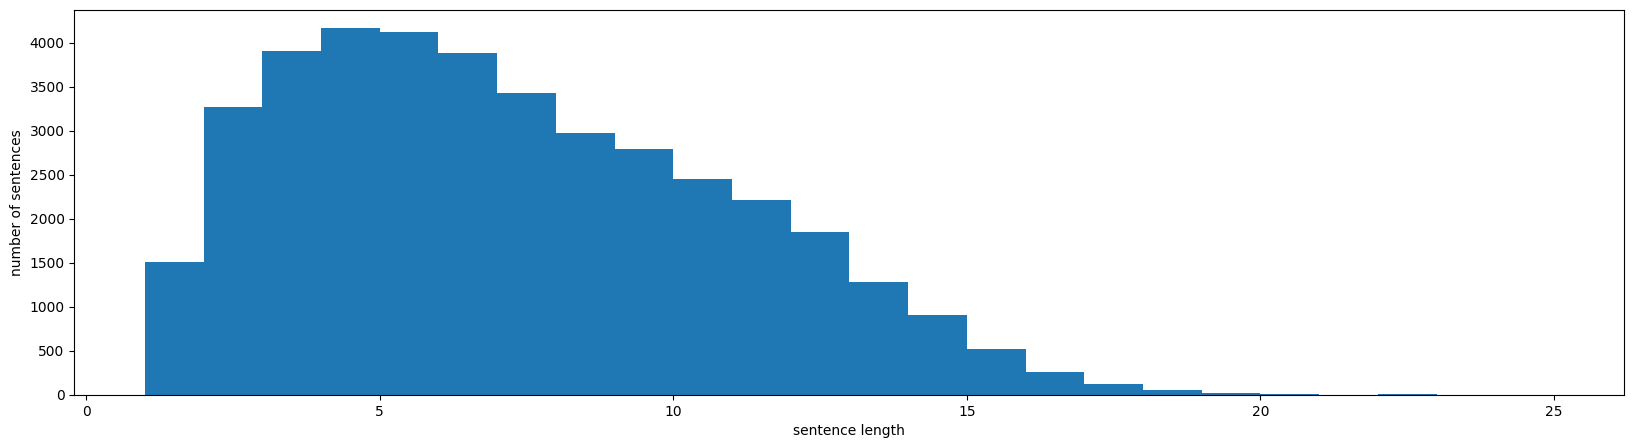

In [18]:
lengths = [len(sentence.split()) for sentence in cleaned_df['content']]
plt.rcParams['figure.figsize'] = [20, 5]
plt.hist(lengths,bins=len(set(lengths)))
plt.xlabel('sentence length')
plt.ylabel('number of sentences')

plt.show()

In [19]:
print('Unique labels:')
for i, label in enumerate(cleaned_df['sentiment'].unique()):
    print('{}) {}'.format(i,label)) 

Unique labels:
0) enthusiasm
1) surprise
2) worry
3) happiness
4) neutral
5) sadness
6) love
7) hate
8) relief
9) boredom
10) fun
11) empty
12) anger


### distribution of sentiments

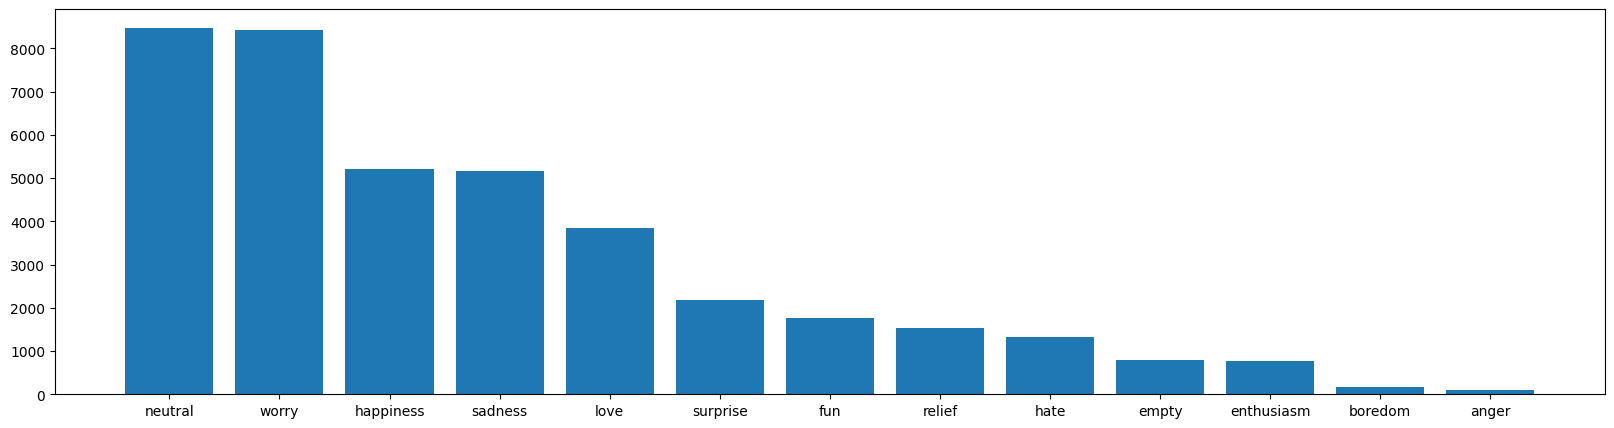

In [20]:
plt.rcParams['figure.figsize'] = [20, 5]
x= list(dict(cleaned_df.sentiment.value_counts()).keys())
y = list(cleaned_df.sentiment.value_counts())
plt.bar(x,y)
plt.show()

In [21]:
cleaned_df['sentiment'].value_counts()

neutral       8480
worry         8429
happiness     5202
sadness       5156
love          3836
surprise      2176
fun           1775
relief        1523
hate          1320
empty          801
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

## To prevent long-tailed distribution problem. we duplicate data for each underrepresented sentiments to be equals to the number of the sentiment with the most number of data

In [22]:
sentiment_count = dict(cleaned_df['sentiment'].value_counts())

# find the sentiment with the largest number of data in training setsentiment,count
max_sentiment = [0,0]
for sentiment,count in sentiment_count.items():
    if(count > max_sentiment[1]):
        max_sentiment[0] = sentiment
        max_sentiment[1] = count
print("The sentiment with the most number of data is {} with {} data".format(max_sentiment[0],max_sentiment[1]))

The sentiment with the most number of data is neutral with 8480 data


### Duplicating sentences from lesser represented sentiments

In [23]:
# We augment data until each sentiment has equal number of data as the sentiment with the largest amount of data
benchmark_count = max_sentiment[1]

# remove the sentiment with the largest amount of data as it need not be augmented
sentiments_to_augment = [sentiment for sentiment in cleaned_df['sentiment'].unique() if sentiment!= max_sentiment[0]]

augmented_df = {
    "content":[],
    "sentiment":[]
}

# duplicate data
for i in tqdm.tqdm(range(len(sentiments_to_augment))):
    sentiment = sentiments_to_augment[i]
    current_no = sentiment_count[sentiment]
    augment_no = benchmark_count -  current_no
    data = cleaned_df[cleaned_df['sentiment'] == sentiment].reset_index(drop=True)
    for i in range(augment_no):
        content = data['content'].iloc[i % len(data)]
        augmented_df['content'].append(content)
        augmented_df['sentiment'].append(sentiment)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 12.95it/s]


In [24]:
cleaned_df = pd.concat([cleaned_df,pd.DataFrame(augmented_df)],ignore_index=True)

### As we can see the distribution in the new dataset is now even

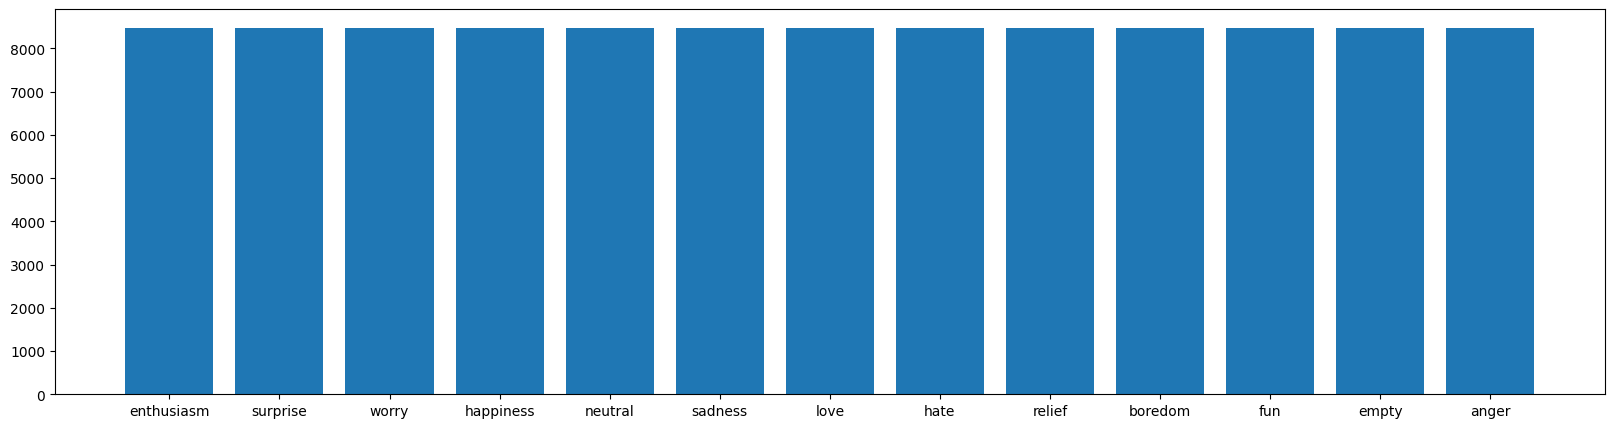

In [25]:
plt.rcParams['figure.figsize'] = [20, 5]
x= list(dict(cleaned_df.sentiment.value_counts()).keys())
y = list(cleaned_df.sentiment.value_counts())
plt.bar(x,y)
plt.show()

In [26]:
cleaned_df['sentiment'].value_counts()

enthusiasm    8480
surprise      8480
worry         8480
happiness     8480
neutral       8480
sadness       8480
love          8480
hate          8480
relief        8480
boredom       8480
fun           8480
empty         8480
anger         8480
Name: sentiment, dtype: int64

In [27]:
# shuffle data
cleaned_df = cleaned_df.sample(frac=1).reset_index(drop=True)

# Converting 'content' column to sequences
---

In [28]:
# Vectir dimension is 50
EMBEDDING_DIM = 50

# get all the content lines train and test
content_lines = list(cleaned_df['content'])
tokeniser_obj = Tokenizer()
tokeniser_obj.fit_on_texts(content_lines)

word_index = tokeniser_obj.word_index
print('Found {} unique tokens'.format(len(word_index)))

sequences = tokeniser_obj.texts_to_sequences(content_lines)

# pad shorter sentence to fit max_length of sentence
content_pad = pad_sequences(sequences,maxlen = max_length)

Found 31044 unique tokens


In [29]:
# number of words has to +1 for the padding
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIM))

In [30]:
embedding_matrix.shape

(31045, 50)

### Map embeddings to the embedding Matrix to feed into Models

In [32]:
count_w2v = 0

for word,i in word_index.items():

    embedding_vector_w2v = word_vector_map.get(word)

    if(embedding_vector_w2v is not None):
        embedding_matrix[i] = embedding_vector_w2v
        count_w2v+=1
        continue
        
print("number of words vectorised from w2v: {}/{}".format(count_w2v,num_words))

number of words vectorised from w2v: 31043/31045


## One-hot encoding the indices

In [33]:
# map labels -> indices
sentiment_labels = cleaned_df['sentiment'].unique().copy()

# index key -> class
label_map = {}

# class -> index key
inverse_label_map = {}
for i, label in enumerate(sentiment_labels):
    label_map[i] = label 
    inverse_label_map[label] = i

In [34]:
# get all keys
indices = list(label_map.keys())
indices

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [35]:
# maps the word to the one hot vector
depth = len(indices)
one_hot_encoding = tf.one_hot(indices,depth)

## map for indices to labels

In [36]:
word_to_vec = {}    
for i,oh in enumerate(one_hot_encoding):
    print("{} --> {}".format(oh,label_map[i]))
    word_to_vec[label_map[i]] = oh.numpy()

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> worry
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> anger
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> surprise
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] --> enthusiasm
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] --> boredom
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] --> relief
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] --> happiness
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] --> love
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] --> neutral
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] --> sadness
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] --> fun
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] --> hate
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] --> empty


In [37]:
word_to_vec

{'worry': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'anger': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'surprise': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'enthusiasm': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'boredom': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'relief': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'happiness': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'love': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32),
 'neutral': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32),
 'sadness': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32),
 'fun': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32),
 'hate': array([0., 0., 0., 0., 0., 0.

## replacing the labels in dataset with one-hot encoding

In [38]:
# getting one-hot encoding for labels

labels=[]
for sentiment in tqdm.tqdm(cleaned_df['sentiment'].values):
    o_h = one_hot_encoding[inverse_label_map[sentiment]]
    labels.append(o_h)
labels = np.asarray(labels)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110240/110240 [00:23<00:00, 4639.64it/s]


In [39]:
TRAINING_SIZE = int(len(content_pad)*0.7)

X_train_pad = content_pad[:TRAINING_SIZE]
y_train = labels[:TRAINING_SIZE]

X_test_pad = content_pad[TRAINING_SIZE:]
y_test = labels[TRAINING_SIZE:]

print("Training size: {}".format(TRAINING_SIZE))
print("Test size: {}".format(len(content_pad)-TRAINING_SIZE))


Training size: 77168
Test size: 33072


# Training and testing RNN,GRU,LSTM and Transformer models

### callback to save weights:

In [40]:
# callback to save the best weights for the model
def saveWeightsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 2,
        save_best_only = True,
        save_weights_only = True,
        mode = mode,
        save_freq=save_freq,
)

## Building a RNN model

In [45]:
def build_RNN_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(num_words,
                               embedding_dim,
                               weights=[embedding_matrix]))

    model.add(
        layers.Bidirectional(
            layers.SimpleRNN(units=64,return_sequences=True)
        ))
    model.add(layers.Dropout(0.2))
    model.add(
        layers.Bidirectional(
            layers.SimpleRNN(units=64)
        ))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13,activation='softmax'))
    
    return model

In [46]:
RNN_model = build_RNN_model(EMBEDDING_DIM,max_length)

RNN_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

RNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 50)          1552250   
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 128)        14720     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              24704     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 13)               

In [47]:
history = RNN_model.fit(X_train_pad,
                        y_train,
                        batch_size=128,
                        epochs = 20,
                        verbose=1,
                        validation_data = (X_test_pad,y_test),
                        callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                                     saveWeightsCallback(
                                         path='./weights/RNN',
                                         monitor = 'val_loss',
                                         mode = 'min',
                                         save_freq='epoch')])         

Epoch 1/20
603/603 [==============================] - ETA: 0s - loss: 2.6330 - accuracy: 0.1112
Epoch 1: val_loss improved from inf to 2.45761, saving model to ./weights/RNN
603/603 [==============================] - 44s 68ms/step - loss: 2.6330 - accuracy: 0.1112 - val_loss: 2.4576 - val_accuracy: 0.1759
Epoch 2/20
603/603 [==============================] - ETA: 0s - loss: 2.4380 - accuracy: 0.1846
Epoch 2: val_loss improved from 2.45761 to 2.31219, saving model to ./weights/RNN
603/603 [==============================] - 49s 82ms/step - loss: 2.4380 - accuracy: 0.1846 - val_loss: 2.3122 - val_accuracy: 0.2330
Epoch 3/20
603/603 [==============================] - ETA: 0s - loss: 2.2931 - accuracy: 0.2358
Epoch 3: val_loss improved from 2.31219 to 2.17477, saving model to ./weights/RNN
603/603 [==============================] - 44s 74ms/step - loss: 2.2931 - accuracy: 0.2358 - val_loss: 2.1748 - val_accuracy: 0.2735
Epoch 4/20
602/603 [============================>.] - ETA: 0s - loss: 2

## Loss over Epochs

Text(0, 0.5, 'loss')

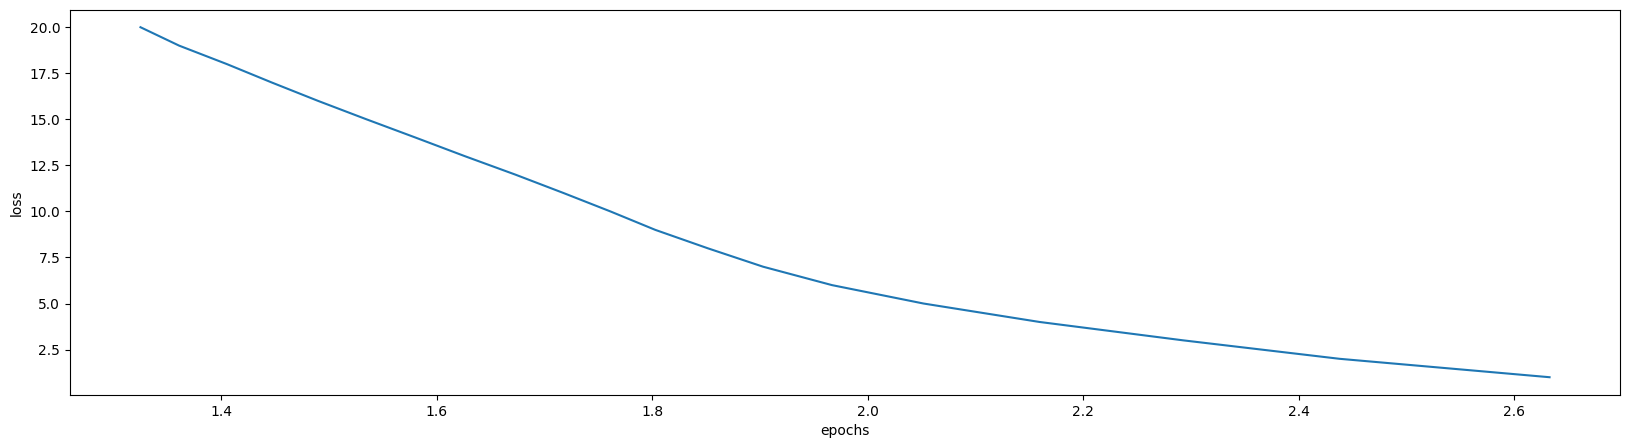

In [48]:
loss = history.history['loss']
plt.plot(loss,[epoch+1 for epoch in range(0,len(loss))])
plt.xlabel('epochs')
plt.ylabel('loss')

## Validation accuracy over Epochs

RNN validation accuracy: 0.536


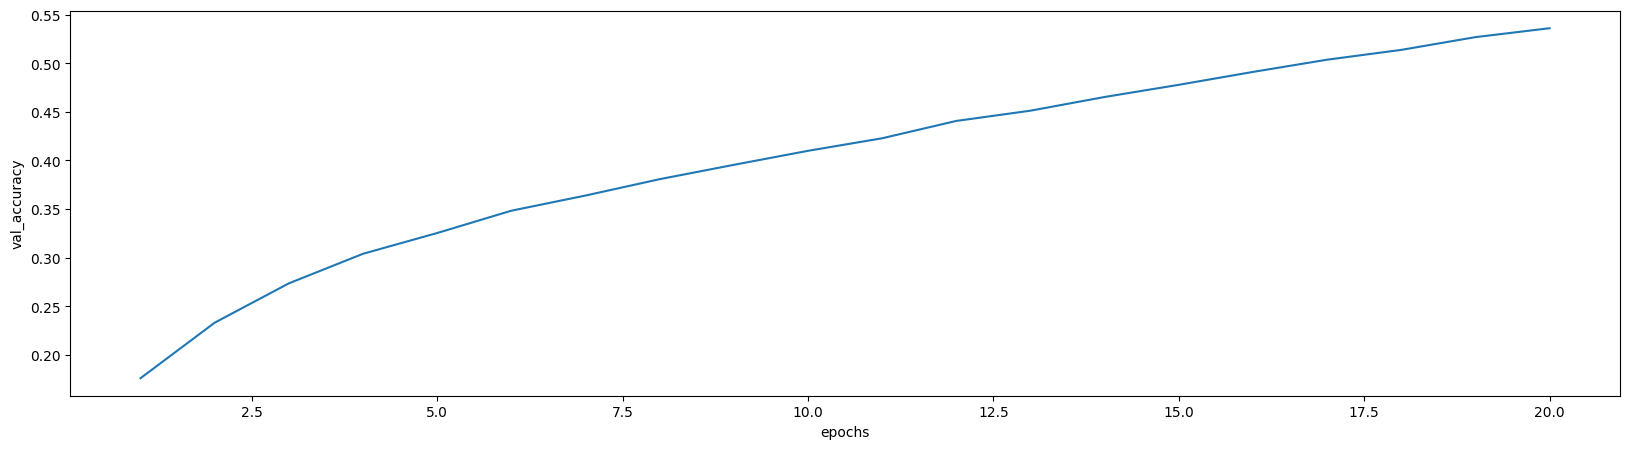

In [49]:
val_accuracy = history.history['val_accuracy']
plt.plot([epoch+1 for epoch in range(0,len(val_accuracy))],val_accuracy)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')

print('RNN validation accuracy: {}'.format(round(val_accuracy[-1],4)))

# Building GRU model

In [50]:
def build_GRU_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(num_words,
                               embedding_dim,
                               weights=[embedding_matrix]))

    model.add(
        layers.Bidirectional(
            layers.GRU(units=64,return_sequences=True)
        ))
    model.add(layers.Dropout(0.2))
    model.add(
        layers.Bidirectional(
            layers.GRU(units=64)
        ))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13,activation='softmax'))
    
    return model

In [51]:
GRU_model = build_GRU_model(EMBEDDING_DIM,max_length)

GRU_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          1552250   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 128)        44544     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 13)               

In [52]:
history = GRU_model.fit(X_train_pad,
                        y_train,
                        batch_size=128,
                        epochs = 20,
                        verbose=1,
                        validation_data = (X_test_pad,y_test))

callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                     saveWeightsCallback(
                         path='./weights/GRU',
                         monitor = 'val_loss',
                         mode = 'min',
                         save_freq='epoch',
                     )],         

Epoch 1/20
603/603 [==============================] - 46s 69ms/step - loss: 2.5116 - accuracy: 0.1362 - val_loss: 2.4338 - val_accuracy: 0.1791
Epoch 2/20
603/603 [==============================] - 53s 88ms/step - loss: 2.3647 - accuracy: 0.2034 - val_loss: 2.3001 - val_accuracy: 0.2277
Epoch 3/20
603/603 [==============================] - 53s 88ms/step - loss: 2.2187 - accuracy: 0.2533 - val_loss: 2.1527 - val_accuracy: 0.2769
Epoch 4/20
603/603 [==============================] - 55s 92ms/step - loss: 2.0768 - accuracy: 0.2988 - val_loss: 2.0331 - val_accuracy: 0.3151
Epoch 5/20
603/603 [==============================] - 58s 96ms/step - loss: 1.9691 - accuracy: 0.3283 - val_loss: 1.9440 - val_accuracy: 0.3385
Epoch 6/20
603/603 [==============================] - 58s 96ms/step - loss: 1.8881 - accuracy: 0.3516 - val_loss: 1.8766 - val_accuracy: 0.3589
Epoch 7/20
603/603 [==============================] - 54s 89ms/step - loss: 1.8280 - accuracy: 0.3694 - val_loss: 1.8288 - val_accuracy:

## Loss over Epochs

Text(0, 0.5, 'loss')

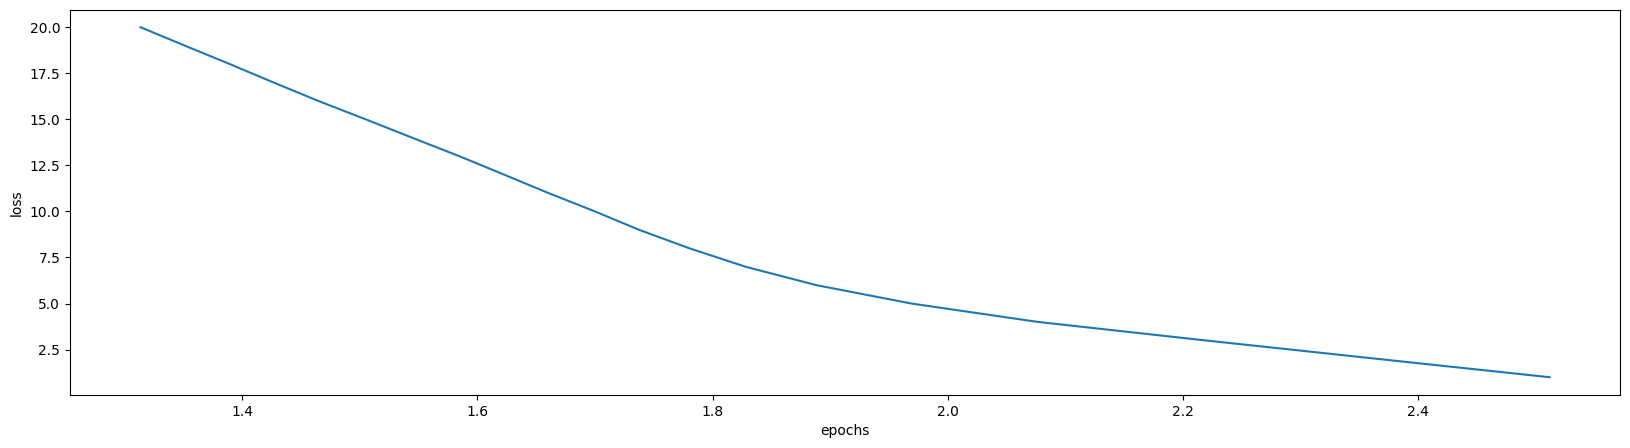

In [53]:
loss = history.history['loss']
plt.plot(loss,[epoch+1 for epoch in range(0,len(loss))])
plt.xlabel('epochs')
plt.ylabel('loss')

## Validation accuracy over Epochs

GRU validation accuracy: 0.5314


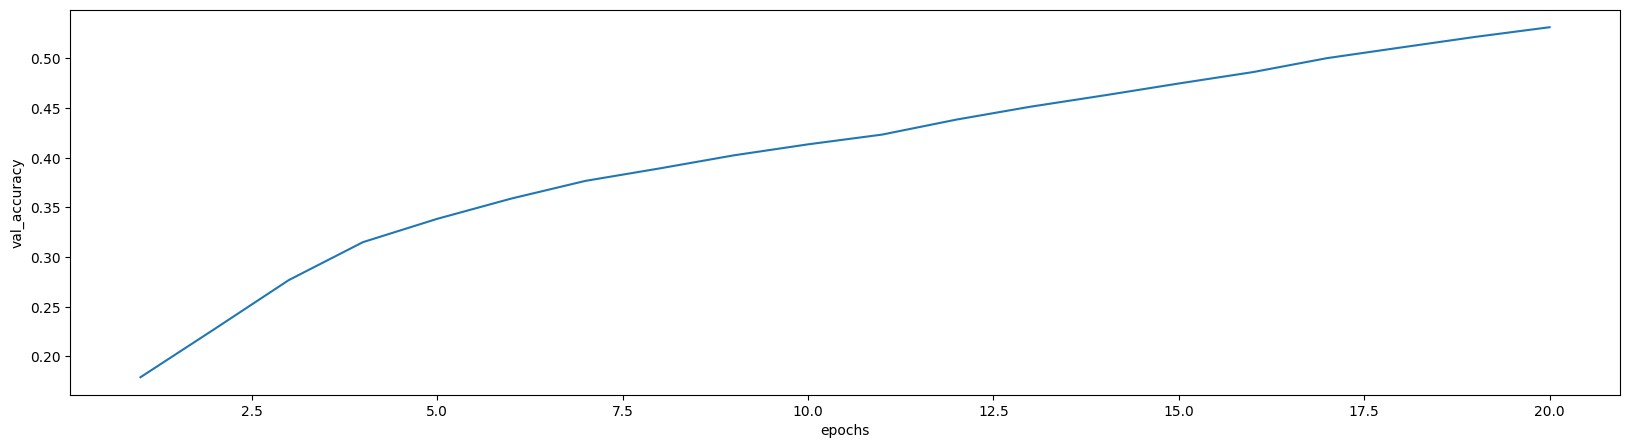

In [54]:
val_accuracy = history.history['val_accuracy']
plt.plot([epoch+1 for epoch in range(0,len(val_accuracy))],val_accuracy)
plt.xlabel('epochs')
plt.ylabel('val_accuracy')
print('GRU validation accuracy: {}'.format(round(val_accuracy[-1],4)))

# LSTM

In [55]:
def build_LSTM_model(embedding_dim,max_length):
    model = keras.models.Sequential()
    model.add(layers.Embedding(input_dim=num_words,
                               output_dim=embedding_dim))
    model.add(layers.Bidirectional(
        layers.LSTM(units=64,return_sequences=True)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Bidirectional(
        layers.LSTM(units=64)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(13,activation='softmax'))
    return model

In [56]:
LSTM_model = build_LSTM_model(EMBEDDING_DIM,max_length)

LSTM_model.compile(
    optimizer= Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 50)          1552250   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 128)        58880     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 13)               

In [57]:
history = LSTM_model.fit(X_train_pad,
                        y_train,
                        batch_size=128,
                        epochs = 20,
                        verbose=1,
                        validation_data = (X_test_pad,y_test),
                        callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                                     saveWeightsCallback(
                                         path='./weights/LSTM',
                                         monitor = 'val_loss',
                                         mode = 'min',
                                         save_freq='epoch')])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2),
                     saveWeightsCallback(
                         path='./weights/LSTM',
                         monitor = 'val_loss',
                         mode = 'min',
                         save_freq='epoch',
                     )],         

Epoch 1/20
603/603 [==============================] - ETA: 0s - loss: 2.4634 - accuracy: 0.1408
Epoch 1: val_loss improved from inf to 2.08432, saving model to ./weights/LSTM
603/603 [==============================] - 87s 132ms/step - loss: 2.4634 - accuracy: 0.1408 - val_loss: 2.0843 - val_accuracy: 0.2762
Epoch 2/20
603/603 [==============================] - ETA: 0s - loss: 1.8703 - accuracy: 0.3502
Epoch 2: val_loss improved from 2.08432 to 1.72856, saving model to ./weights/LSTM
603/603 [==============================] - 79s 131ms/step - loss: 1.8703 - accuracy: 0.3502 - val_loss: 1.7286 - val_accuracy: 0.4179
Epoch 3/20
603/603 [==============================] - ETA: 0s - loss: 1.6055 - accuracy: 0.4598
Epoch 3: val_loss improved from 1.72856 to 1.58921, saving model to ./weights/LSTM
603/603 [==============================] - 72s 119ms/step - loss: 1.6055 - accuracy: 0.4598 - val_loss: 1.5892 - val_accuracy: 0.4826
Epoch 4/20
603/603 [==============================] - ETA: 0s - l

## Loss over epochs for LSTM model

Text(0, 0.5, 'loss')

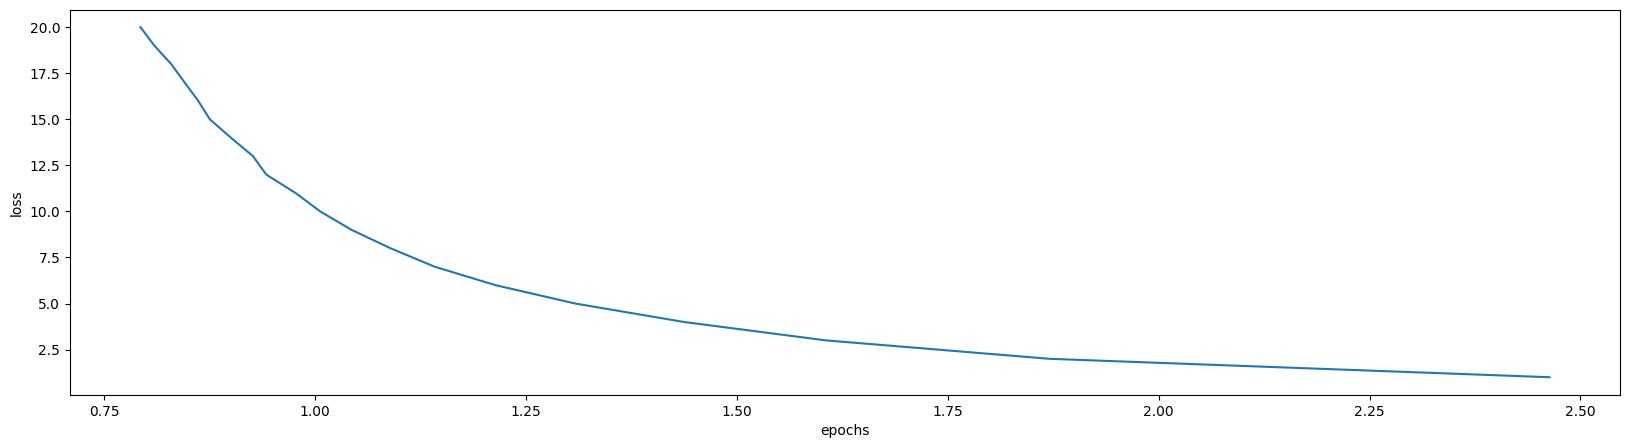

In [58]:
loss = history.history['loss']
plt.plot(loss,[epoch+1 for epoch in range(0,len(loss))])
plt.xlabel('epochs')
plt.ylabel('loss')

## Accuracy over epochs for LSTM model

LSTM validation accuracy: 0.6468


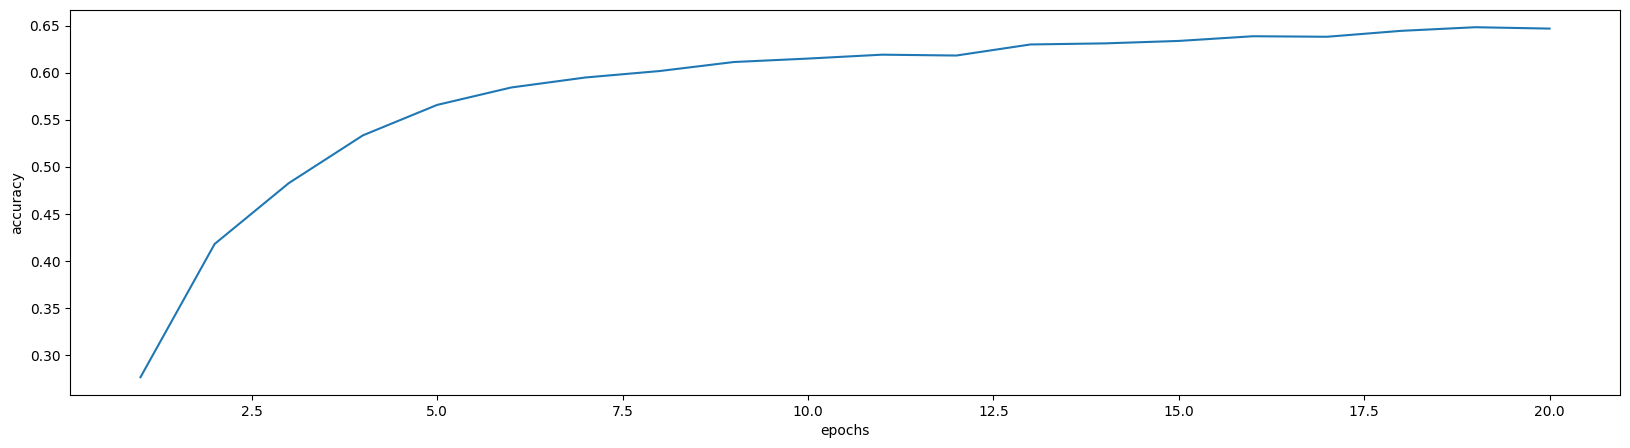

In [59]:
val_accuracy = history.history['val_accuracy']
plt.plot([epoch+1 for epoch in range(0,len(val_accuracy))],val_accuracy)
plt.xlabel('epochs')
plt.ylabel('accuracy')
print('LSTM validation accuracy: {}'.format(round(val_accuracy[-1],4)))

# Transformers (Hwan Add Plz)